In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
    
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, NNConv
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

from sklearn.metrics import roc_auc_score

from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
%run dataset_ep.ipynb

DATASET LOADED
Data(x=[26, 1], edge_index=[2, 26], edge_attr=[26, 1], y=[26, 19])


Processing...
Done!


In [4]:
torch.manual_seed(42)
dataset = dataset_ep.shuffle()

print(f'Number of graphs total: {len(dataset)}')
print(dataset[0])
print(len(dataset))

Number of graphs total: 110
Data(x=[26, 1], edge_index=[2, 25], edge_attr=[25, 1], y=[25, 19])
110


In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

NUM_GRAPHS_PER_BATCH = len(dataset)
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

In [6]:
x = []
edge_index = []
edge_attr = []
y = []
for batch in train_loader:
    x = batch.x
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    y = batch.y

data = Data(x=x, 
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            ) 

num_nodes = data.x.shape[0]
print(data)

Data(x=[3020, 1], edge_index=[2, 3216], edge_attr=[3216, 1], y=[3216, 19])


In [7]:
transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.10, num_test=0.20, neg_sampling_ratio = 1.0, is_undirected=True, 
                      add_negative_train_samples=False),
])
data = transform(data)

In [8]:
train_data, val_data, test_data = data
print(train_data)
print(val_data)
print(test_data)

Data(x=[3020, 1], edge_index=[2, 2482], edge_attr=[2482, 1], y=[3216, 19], edge_label=[1241], edge_label_index=[2, 1241])
Data(x=[3020, 1], edge_index=[2, 2482], edge_attr=[2482, 1], y=[3216, 19], edge_label=[354], edge_label_index=[2, 354])
Data(x=[3020, 1], edge_index=[2, 2836], edge_attr=[2836, 1], y=[3216, 19], edge_label=[708], edge_label_index=[2, 708])


In [9]:
class GCNNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        

    def encode(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [28]:
model = GCNNN(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCNNN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 128)
)
Number of parameters:  16768


In [29]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data)

    # negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

Epoch: 001, Loss: 56.1522, Val: 0.4550, Test: 0.4717
Epoch: 002, Loss: 18.4321, Val: 0.4583, Test: 0.4670
Epoch: 003, Loss: 22.1927, Val: 0.4781, Test: 0.4717
Epoch: 004, Loss: 30.4620, Val: 0.4803, Test: 0.4717
Epoch: 005, Loss: 29.6943, Val: 0.4711, Test: 0.4685
Epoch: 006, Loss: 24.6561, Val: 0.4633, Test: 0.4771
Epoch: 007, Loss: 17.8316, Val: 0.4539, Test: 0.4754
Epoch: 008, Loss: 12.8844, Val: 0.4689, Test: 0.4659
Epoch: 009, Loss: 9.5627, Val: 0.4634, Test: 0.4694
Epoch: 010, Loss: 7.7000, Val: 0.4776, Test: 0.4757
Epoch: 011, Loss: 5.8103, Val: 0.4809, Test: 0.4810
Epoch: 012, Loss: 4.9672, Val: 0.4843, Test: 0.4852
Epoch: 013, Loss: 4.3184, Val: 0.4840, Test: 0.4863
Epoch: 014, Loss: 3.6316, Val: 0.4837, Test: 0.4869
Epoch: 015, Loss: 3.0975, Val: 0.4836, Test: 0.4878
Epoch: 016, Loss: 3.0017, Val: 0.4836, Test: 0.4880
Epoch: 017, Loss: 2.5755, Val: 0.4835, Test: 0.4882
Epoch: 018, Loss: 2.4289, Val: 0.4834, Test: 0.4879
Epoch: 019, Loss: 2.1452, Val: 0.4836, Test: 0.4875
Epoc

Epoch: 160, Loss: 0.6835, Val: 0.5161, Test: 0.5158
Epoch: 161, Loss: 0.6821, Val: 0.5164, Test: 0.5161
Epoch: 162, Loss: 0.6841, Val: 0.5167, Test: 0.5162
Epoch: 163, Loss: 0.6833, Val: 0.5169, Test: 0.5166
Epoch: 164, Loss: 0.6839, Val: 0.5174, Test: 0.5169
Epoch: 165, Loss: 0.6830, Val: 0.5178, Test: 0.5171
Epoch: 166, Loss: 0.6850, Val: 0.5185, Test: 0.5177
Epoch: 167, Loss: 0.6842, Val: 0.5191, Test: 0.5181
Epoch: 168, Loss: 0.6838, Val: 0.5203, Test: 0.5186
Epoch: 169, Loss: 0.6819, Val: 0.5211, Test: 0.5189
Epoch: 170, Loss: 0.6831, Val: 0.5216, Test: 0.5192
Epoch: 171, Loss: 0.6839, Val: 0.5223, Test: 0.5195
Epoch: 172, Loss: 0.6832, Val: 0.5229, Test: 0.5200
Epoch: 173, Loss: 0.6806, Val: 0.5233, Test: 0.5202
Epoch: 174, Loss: 0.6824, Val: 0.5234, Test: 0.5204
Epoch: 175, Loss: 0.6817, Val: 0.5235, Test: 0.5207
Epoch: 176, Loss: 0.6827, Val: 0.5238, Test: 0.5210
Epoch: 177, Loss: 0.6827, Val: 0.5244, Test: 0.5212
Epoch: 178, Loss: 0.6820, Val: 0.5245, Test: 0.5217
Epoch: 179, 

Epoch: 320, Loss: 0.6506, Val: 0.5908, Test: 0.5839
Epoch: 321, Loss: 0.6560, Val: 0.5907, Test: 0.5839
Epoch: 322, Loss: 0.6527, Val: 0.5907, Test: 0.5837
Epoch: 323, Loss: 0.6524, Val: 0.5906, Test: 0.5836
Epoch: 324, Loss: 0.6573, Val: 0.5905, Test: 0.5837
Epoch: 325, Loss: 0.6559, Val: 0.5903, Test: 0.5836
Epoch: 326, Loss: 0.6498, Val: 0.5901, Test: 0.5838
Epoch: 327, Loss: 0.6594, Val: 0.5902, Test: 0.5841
Epoch: 328, Loss: 0.6508, Val: 0.5900, Test: 0.5840
Epoch: 329, Loss: 0.6510, Val: 0.5902, Test: 0.5842
Epoch: 330, Loss: 0.6483, Val: 0.5904, Test: 0.5843
Epoch: 331, Loss: 0.6576, Val: 0.5904, Test: 0.5848
Epoch: 332, Loss: 0.6558, Val: 0.5908, Test: 0.5854
Epoch: 333, Loss: 0.6477, Val: 0.5911, Test: 0.5853
Epoch: 334, Loss: 0.6572, Val: 0.5913, Test: 0.5862
Epoch: 335, Loss: 0.6511, Val: 0.5918, Test: 0.5864
Epoch: 336, Loss: 0.6482, Val: 0.5915, Test: 0.5868
Epoch: 337, Loss: 0.6490, Val: 0.5917, Test: 0.5868
Epoch: 338, Loss: 0.6518, Val: 0.5916, Test: 0.5868
Epoch: 339, 

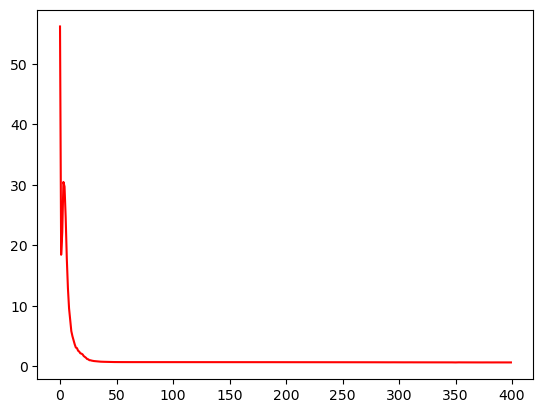

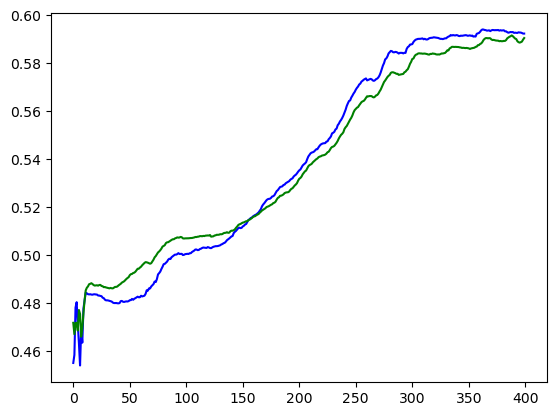

In [31]:
loss_values, val_auc_values, test_auc_values, = [], [], []

best_val_auc = final_test_auc = 0
for epoch in range(1, 401):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_values.append(loss.item())
    val_auc_values.append(val_auc)
    test_auc_values.append(test_auc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, 'f'Test: {test_auc:.4f}')


plt.plot(loss_values, 'r',)
plt.savefig('loss_lp.png')
plt.show()
plt.plot(val_auc_values, 'b', test_auc_values, 'g' )
plt.savefig('acc_lp.png')
plt.show()

In [69]:
z = model.encode(test_data)
final_edge_index = model.decode_all(z)

In [70]:
final_edge_index.shape

torch.Size([2, 4742318])